**Проект заточен на то, чтобы предсказать культуру производственной безопасности (КПБ) каждого работника с помощью методов ML и DL. В конце концов, выбрать наилучшую модель для дальнейшего пользования университетом РГУ нефти и газа имени Губкина.**

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Просмотр данных и предобработка

In [2]:
file_2020 = pd.read_excel('/kaggle/input/data-assessment/2020.xlsx')
file_2020_addition = pd.read_excel('/kaggle/input/data-assessment/2020_.xlsx')
file_2021 = pd.read_excel('/kaggle/input/data-assessment/2021.xlsx')
file_2022_2023 = pd.read_excel('/kaggle/input/data-assessment/2022_2023.xlsx')

**Сначала приведём все столбцы к одинаковому формату.**

In [ ]:
file_2020.columns

In [3]:
file_2020.columns = file_2020_addition.columns = file_2021.columns = file_2022_2023.columns = [
    'Age',
    'Experience',
    'Post',
    'The ability to perform security',
    'There were security errors',
    'There are risks at work',
    'Security status',
    "Contribution to the company's security",
    'Participation in the audit',
    'Interrupt work in case of danger',
    'КПБ'
]

In [4]:
file_2020.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


**Так как столбцы во всех файлах одинаковые, сделаем concat.**

In [5]:
data = pd.concat([file_2020, file_2020_addition, file_2021, file_2022_2023], axis=0, ignore_index=True)
assert len(data) == len(file_2020) + len(file_2020_addition) + len(file_2021) + len(file_2022_2023)

In [6]:
data.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
0,46,20,Руководитель (администрация),Да,Нет,Да,5.0,75,Да,Да,4.296875
1,37,15,Руководитель (администрация),Да,Нет,Нет,5.0,100,Да,Да,4.828125
2,40,15,Руководитель (администрация),Да,Нет,Да,5.0,100,Нет,Да,4.656250
3,41,19,Линейный руководитель (производственные подраз...,Да,Да,Да,5.0,100,Да,Да,4.625000
4,38,17,Рабочий,Да,Да,Да,5.0,100,Нет,Затрудняюсь ответить,4.593750


In [5]:
len(data)

30659

**Теперь необходимо исключить пропуски из данных.**

In [8]:
data[data.isnull().any(axis=1)]

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger,КПБ
716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.861557
718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.949581
820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data = data.dropna()
len(data)

30633

**Проверим данные на наличие аномалий в каждом столбце.**

In [ ]:
data.describe()

In [ ]:
data.dtypes

In [7]:
''' Функции для работы с неопределёнными значениями'''

def not_int(x):
    if type(x) != int:
        return True

def not_float(x):
    if type(x) != float:
        return True
    
def clear_data(data, label, func):
    indexes = data[data[label].apply(lambda x: func(x)) == True].index
    print(f'количество аномалий: {len(data[data[label].apply(lambda x: func(x)) == True])}')
    data = data.drop(indexes)
    return data

In [8]:
data = clear_data(data, 'Age', not_int)

количество аномалий: 122


In [9]:
data = clear_data(data, 'Experience', not_int)

количество аномалий: 1134


In [10]:
data = clear_data(data, "Contribution to the company's security", not_int)

количество аномалий: 161


In [11]:
print(f'Количество данных после удаления аномалий в числовых столбцах: {len(data)}')

Количество данных после удаления аномалий в числовых столбцах: 29216


In [15]:
data.columns

Index(['Age', 'Experience', 'Post', 'The ability to perform security',
       'There were security errors', 'There are risks at work',
       'Security status', 'Contribution to the company's security',
       'Participation in the audit', 'Interrupt work in case of danger',
       'КПБ'],
      dtype='object')

In [12]:
print(data['Post'].nunique())
print(data['The ability to perform security'].nunique())
print(data['There were security errors'].nunique())
print(data['There are risks at work'].nunique())
print(data['Participation in the audit'].nunique())
print(data['Interrupt work in case of danger'].nunique())

8
3
3
3
2
3


**Можно сделать вывод, что в категориальных столбцах нет аномалий, поэтому оставим всё как есть.**

# Визуализация и работа с выбросами

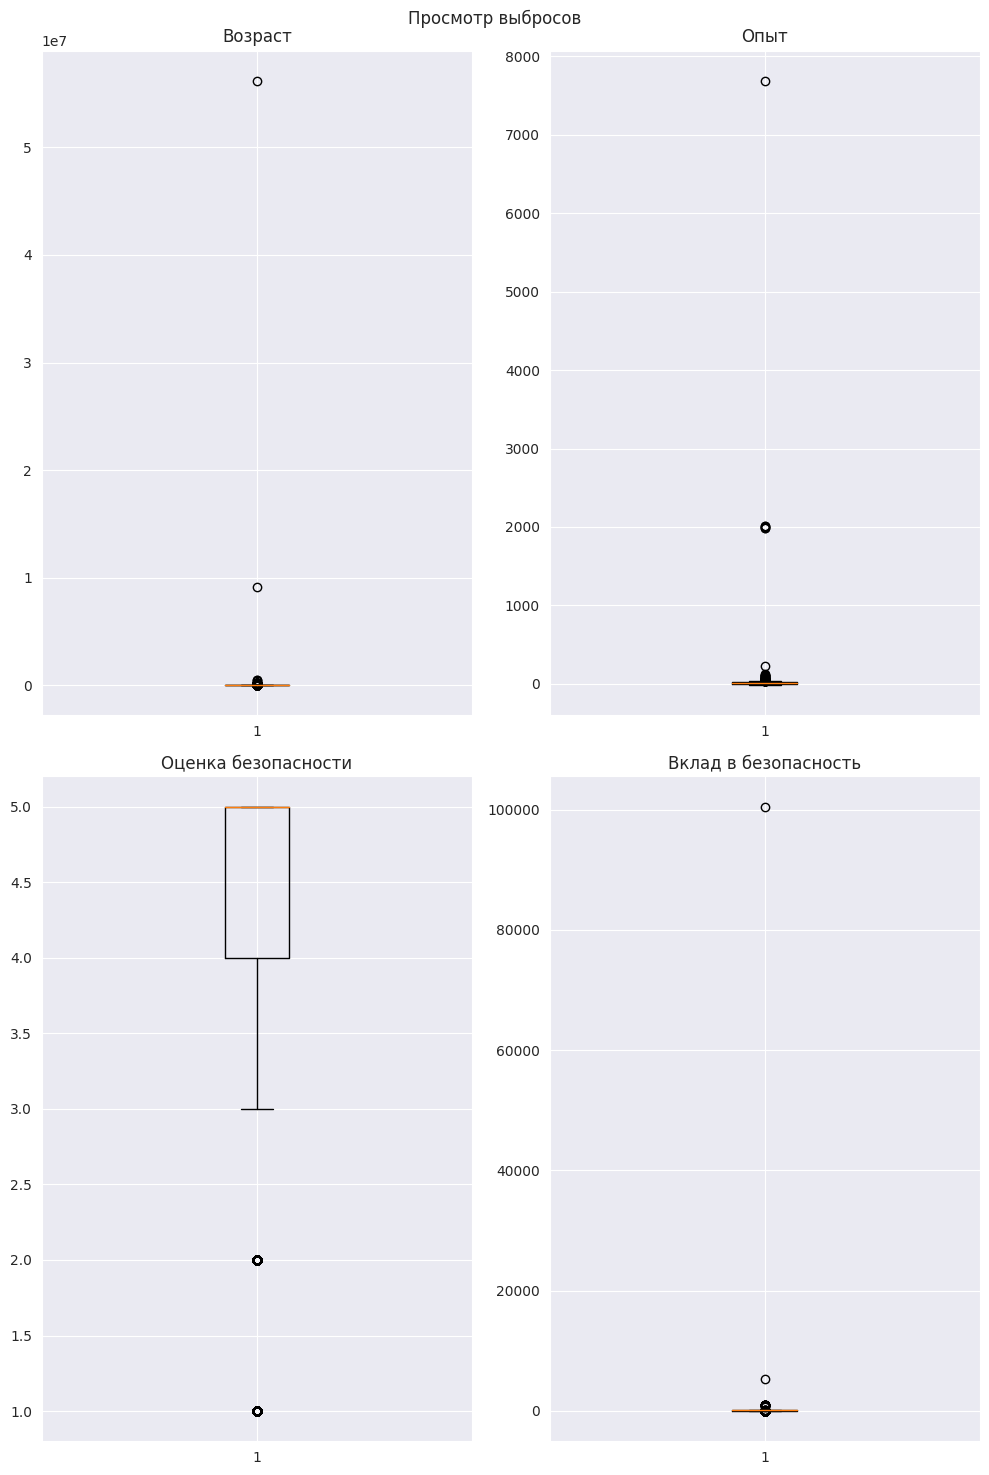

In [17]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [13]:
data = data[(data['Age'] <= 100) & (data['Age'] >= 18)]
data = data[(data['Experience'] <= 60) & (data['Experience'] >= 0)]
data = data[(data["Contribution to the company's security"] <= 100) &
            (data["Contribution to the company's security"] >= 0)]

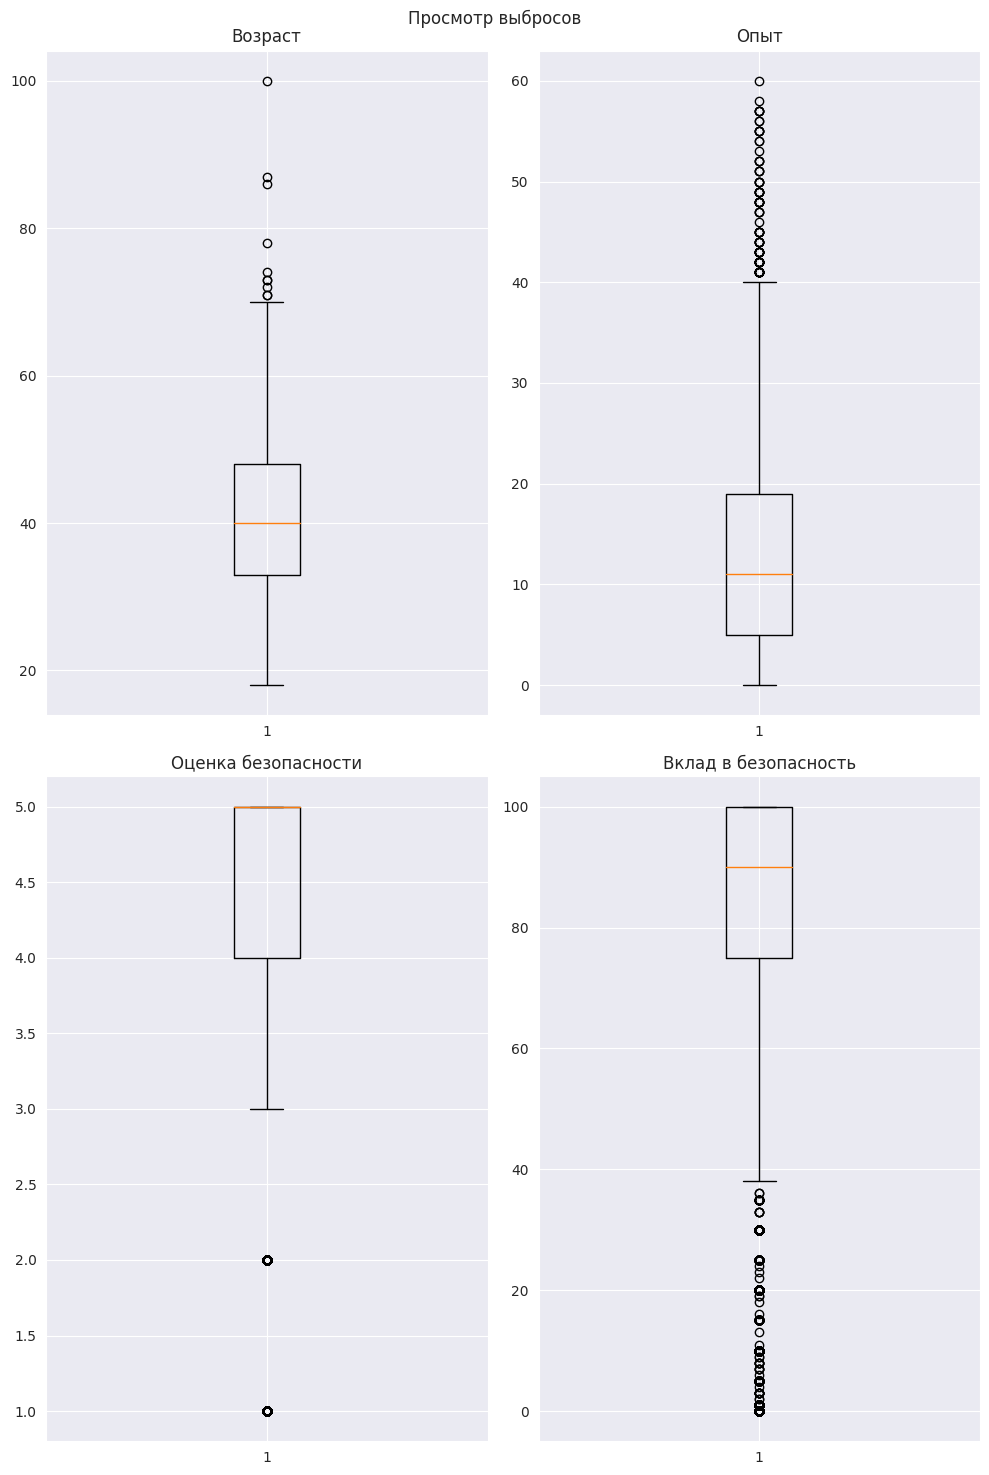

In [64]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Просмотр выбросов')
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0, 0].boxplot(data['Age'])
axs[0, 0].set_title('Возраст')
axs[0, 1].boxplot(data['Experience'])
axs[0, 1].set_title('Опыт')
axs[1, 0].boxplot(data['Security status'])
axs[1, 0].set_title('Оценка безопасности')
axs[1, 1].boxplot(data["Contribution to the company's security"])
axs[1, 1].set_title('Вклад в безопасность')
fig.tight_layout()

In [14]:
len(data)

29022

# Подготовка данных к модели

In [15]:
X = data.drop(['КПБ'], axis=1)
y = data[['КПБ']]

In [ ]:
y.dtypes

In [ ]:
X.dtypes

In [16]:
categorical_columns = ['Post', 'The ability to perform security', 'There were security errors',
                      'There are risks at work', 'Participation in the audit',
                      'Interrupt work in case of danger']
int_columns = ['Age', 'Experience', "Contribution to the company's security"]
X[int_columns] = X[int_columns].astype('int32')
num_columns = ['Age', 'Experience', 'Security status', "Contribution to the company's security"]

In [20]:
assert len(categorical_columns) + len(num_columns) == 10

In [17]:
def encode(df, cols):
    encode_dict = {}
    for col in cols:
        print(f'{col}: преобразовалась')
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(df[col].values) 
        df[col] = label_encoder.transform(df[col].values)
        encode_dict[col] = label_encoder
    return df, encode_dict

X_cat, encode_dict = encode(X, categorical_columns)

Post: преобразовалась
The ability to perform security: преобразовалась
There were security errors: преобразовалась
There are risks at work: преобразовалась
Participation in the audit: преобразовалась
Interrupt work in case of danger: преобразовалась


In [ ]:
encode_dict

In [18]:
scaler_dict = {}
for col in num_columns:
    scaler = StandardScaler()
    scaler_dict[col] = scaler.fit(X[col].values.reshape(-1, 1))
    X[col] = scaler_dict[col].transform(X[col].values.reshape(-1, 1))

In [17]:
X.head()

,Age,Experience,Post,The ability to perform security,There were security errors,There are risks at work,Security status,Contribution to the company's security,Participation in the audit,Interrupt work in case of danger
0,0.592549,0.788456,3,0,2,0,0.758893,-0.300736,0,0
1,-0.365291,0.242006,3,0,2,2,0.758893,0.837947,0,0
2,-0.046011,0.242006,3,0,2,0,0.758893,0.837947,1,0
3,0.060416,0.679166,0,0,0,0,0.758893,0.837947,0,0
4,-0.258864,0.460586,2,0,0,0,0.758893,0.837947,1,1


In [ ]:
scaler_dict

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Baseline модель

In [19]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, train_size=0.9, \
                                                                     random_state=42)

base_model = LinearRegression()
base_model.fit(X_train_base, y_train_base)
preds = base_model.predict(X_val_base)

print(f'Вычисленное отклонение rmse: {np.sqrt(mean_squared_error(y_val_base, preds))}')

Вычисленное отклонение rmse: 0.43718517743224383


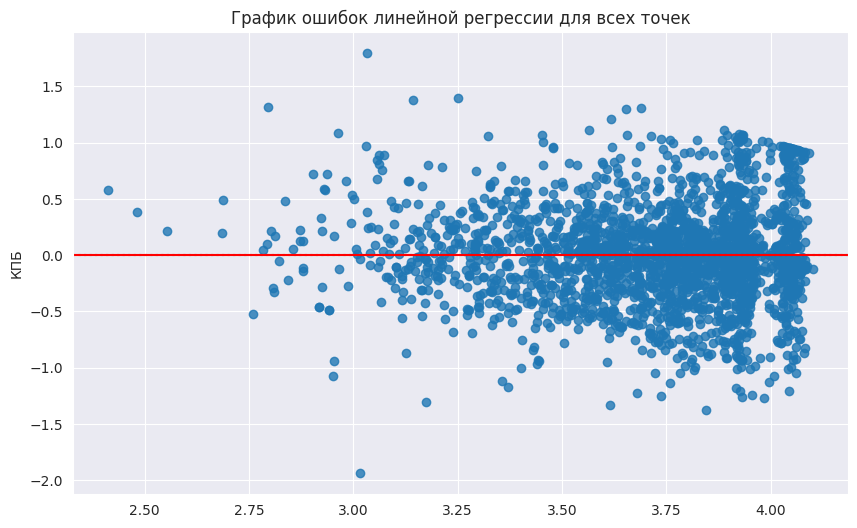

In [20]:
plt.figure(figsize=(10,6), dpi=100)
sns.residplot(x=preds, y=y_val_base);
plt.axhline(y=0, color='r');
plt.title('График ошибок линейной регрессии для всех точек');

# XGBoost, Catboost

In [ ]:
def training_model_with_randomsearch(model, X_train, y_train, X_test, y_test, params_dict):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_dict,
        n_iter=10,
        cv=3,
        scoring='neg_mean_squared_error', 
        verbose=1
    )
    random_search.fit(X_train, y_train)
    preds = random_search.predict(X_test)
    print("Лучшие гиперпараметры:", random_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

In [ ]:
def training_model_with_gridsearch(model, X_train, y_train, X_test, y_test, params_dict):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params_dict,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    preds = grid_search.predict(X_test)
    print("Лучшие гиперпараметры:", grid_search.best_params_)
    print(f'Вычисленное значение rmse: {np.sqrt(mean_squared_error(y_test, preds))}')

**XGBoost**

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_randomsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

In [ ]:
params_dict = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [5, 7, 9],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(tree_method='gpu_hist', random_state=42)
training_model_with_gridsearch(xgb, X_train_base, y_train_base, X_val_base, y_val_base, params_dict)

**Catboost**

In [ ]:
params = {
    'depth': [8, 10, 12],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 700, 900],
    'l2_leaf_reg': [7, 9, 11],
}
cat = CatBoostRegressor(task_type='GPU', verbose=0)

In [ ]:
training_model_with_randomsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

In [ ]:
training_model_with_gridsearch(cat, X_train_base, y_train_base, X_val_base, y_val_base, params)

# Подготовка данных к нейронке

In [20]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=42)

In [79]:
class MyDataset(Dataset):
    def __init__(self, df, num_cols, cat_cols, targets):
        self.num_data = df[num_cols]
        self.cat_data = df[cat_cols]
        self.targets = targets

    def __len__(self):
        return len(self.num_data) 

    def __getitem__(self, idx):
        return torch.FloatTensor(self.num_data.iloc[idx].values), torch.LongTensor(self.cat_data.iloc[idx].values), (self.targets.iloc[idx].values).astype('float32')

In [80]:
train_dataset = MyDataset(X_train_new, num_columns, categorical_columns, y_train_new)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = MyDataset(X_val, num_columns, categorical_columns, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [23]:
for nums, cats, targs in train_loader:
    print(targs)
    break

tensor([[3.6250],
        [4.0625],
        [3.4219],
        [4.3125],
        [3.8750],
        [3.0156],
        [4.0938],
        [2.7812],
        [4.2031],
        [4.1406],
        [3.4688],
        [2.7500],
        [3.8281],
        [4.0625],
        [3.0312],
        [2.8750],
        [3.9219],
        [3.6406],
        [2.9844],
        [4.1562],
        [4.7812],
        [3.9844],
        [4.9375],
        [3.8750],
        [3.8906],
        [4.5781],
        [3.8750],
        [3.6250],
        [2.8906],
        [4.7500],
        [4.2188],
        [3.0000],
        [3.4531],
        [3.3125],
        [3.5469],
        [4.7812],
        [3.4219],
        [3.7812],
        [3.7031],
        [3.7812],
        [3.3594],
        [3.1562],
        [3.0312],
        [2.2656],
        [3.0625],
        [3.5312],
        [3.5000],
        [3.5469],
        [3.1562],
        [3.0625],
        [3.6719],
        [3.8906],
        [3.7500],
        [4.0625],
        [2.6562],
        [4

# Архитектура нейросети

**Определяем количество эмбеддингов.**

In [65]:
cat_dims = [X[col].nunique() for col in categorical_columns]
cat_embs = [(dim, min(50,(dim+1)//2)) for dim in cat_dims]
cat_embs

[(8, 4), (3, 2), (3, 2), (3, 2), (2, 1), (3, 2)]

In [107]:
class MyModel(nn.Module):
    def __init__(self, input_shape, embeddings_shape):
        super(MyModel, self).__init__()
        self.relu = nn.ReLU()

        # Создание эмбеддингов
        self.embeddings = nn.ModuleList(nn.Embedding(dim1,dim2) for dim1, dim2 in embeddings_shape)
        len_emb = sum([dim2 for dim1, dim2 in embeddings_shape])

        # Полносвязные слои с дропаутом и пакетной нормализацией
        self.linear_1 = nn.Linear(input_shape + len_emb, 128)
        self.dropout1 = nn.Dropout(0.35)

        self.bn1 = nn.BatchNorm1d(128)
        
        self.linear_2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.35)

        self.bn2 = nn.BatchNorm1d(64)
        
        self.linear_3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.35)

        self.bn3 = nn.BatchNorm1d(32)
        
        self.linear_4 = nn.Linear(32, 16)
        self.dropout4 = nn.Dropout(0.35)

        self.bn4 = nn.BatchNorm1d(16)
        
        self.linear_5 = nn.Linear(16, 1)
        
    def forward(self, num_batch, cat_batch):
        # Работаем с категориальными данными 
        x_cat = [embedding_layer(cat_batch[:, i]) for i, embedding_layer in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, 1)
        x = torch.cat([x_cat, num_batch], 1)

        # Основной проход
        x = self.relu(self.linear_1(x))
        x = self.dropout1(x)
        
        x = self.bn1(x)
        
        x = self.relu(self.linear_2(x))
        x = self.dropout2(x)
        
        x = self.bn2(x)
        
        x = self.relu(self.linear_3(x))
        x = self.dropout3(x)
        
        x = self.bn3(x)
        
        x = self.relu(self.linear_4(x))
        x = self.dropout4(x)
        
        x = self.bn4(x)
        
        out = self.linear_5(x)
        return out

In [108]:
model = MyModel(len(num_columns), cat_embs).to(device)
print(model)

MyModel(
  (relu): ReLU()
  (embeddings): ModuleList(
    (0): Embedding(8, 4)
    (1-3): 3 x Embedding(3, 2)
    (4): Embedding(2, 1)
    (5): Embedding(3, 2)
  )
  (linear_1): Linear(in_features=17, out_features=128, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=64, out_features=32, bias=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=32, out_features=16, bias=True)
  (dropout4): Dropout(p=0.35, inplace=False)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_5): Linear(in_features=16, 

In [109]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses, val_losses = [], []
y_preds, y_trues = [], []
epochs = 40
for epoch in range(epochs):
    # ТРЕНИРОВКА
    model.train()
    train_loop = tqdm(train_loader)
    train_loss_epoch = 0
    for num_data, cat_data, targets in train_loop:
        num_data = num_data.to(device)
        cat_data = cat_data.to(device)
        targets = targets.to(device)
        
        # прямой проход
        preds = model(num_data, cat_data)
        loss = criterion(preds, targets)
        train_loss_epoch += loss.item()
        

        # обратное распространение
        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(mean_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, train_loss: {mean_train_loss:.4f}")

    # ВАЛИДАЦИЯ
    model.eval()
    val_loop = tqdm(val_loader)
    val_loss_epoch = 0
    with torch.no_grad():
        for num_data, cat_data, targets in val_loop:
            num_data = num_data.to(device)
            cat_data = cat_data.to(device)
            targets = targets.to(device)

            # оценка
            preds = model(num_data, cat_data)
            loss = criterion(preds, targets)
            val_loss_epoch += loss.item()

            y_preds.append(preds)
            y_trues.append(targets)

    mean_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(mean_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, val_loss: {mean_val_loss:.4f}")

100%|██████████| 327/327 [00:03<00:00, 86.59it/s]


Epoch 1/40, train_loss: 7.1019


100%|██████████| 37/37 [00:00<00:00, 110.94it/s]


Epoch 1/40, val_loss: 0.6938


100%|██████████| 327/327 [00:03<00:00, 85.44it/s]


Epoch 2/40, train_loss: 0.7513


100%|██████████| 37/37 [00:00<00:00, 112.27it/s]


Epoch 2/40, val_loss: 0.2067


100%|██████████| 327/327 [00:03<00:00, 84.51it/s]


Epoch 3/40, train_loss: 0.3990


100%|██████████| 37/37 [00:00<00:00, 108.62it/s]


Epoch 3/40, val_loss: 0.2021


100%|██████████| 327/327 [00:03<00:00, 85.04it/s]


Epoch 4/40, train_loss: 0.2809


100%|██████████| 37/37 [00:00<00:00, 112.02it/s]


Epoch 4/40, val_loss: 0.2010


100%|██████████| 327/327 [00:03<00:00, 84.60it/s]


Epoch 5/40, train_loss: 0.2368


100%|██████████| 37/37 [00:00<00:00, 111.40it/s]


Epoch 5/40, val_loss: 0.2003


100%|██████████| 327/327 [00:03<00:00, 84.00it/s]


Epoch 6/40, train_loss: 0.2151


100%|██████████| 37/37 [00:00<00:00, 111.85it/s]


Epoch 6/40, val_loss: 0.1973


100%|██████████| 327/327 [00:03<00:00, 86.35it/s]


Epoch 7/40, train_loss: 0.2074


100%|██████████| 37/37 [00:00<00:00, 113.13it/s]


Epoch 7/40, val_loss: 0.1929


100%|██████████| 327/327 [00:03<00:00, 86.58it/s]


Epoch 8/40, train_loss: 0.2021


100%|██████████| 37/37 [00:00<00:00, 112.80it/s]


Epoch 8/40, val_loss: 0.1933


100%|██████████| 327/327 [00:03<00:00, 85.91it/s]


Epoch 9/40, train_loss: 0.2002


100%|██████████| 37/37 [00:00<00:00, 111.78it/s]


Epoch 9/40, val_loss: 0.1933


100%|██████████| 327/327 [00:03<00:00, 86.29it/s]


Epoch 10/40, train_loss: 0.1985


100%|██████████| 37/37 [00:00<00:00, 109.30it/s]


Epoch 10/40, val_loss: 0.1897


100%|██████████| 327/327 [00:03<00:00, 85.05it/s]


Epoch 11/40, train_loss: 0.1973


100%|██████████| 37/37 [00:00<00:00, 112.03it/s]


Epoch 11/40, val_loss: 0.1906


100%|██████████| 327/327 [00:03<00:00, 85.32it/s]


Epoch 12/40, train_loss: 0.1949


100%|██████████| 37/37 [00:00<00:00, 101.66it/s]


Epoch 12/40, val_loss: 0.1880


100%|██████████| 327/327 [00:04<00:00, 81.27it/s]


Epoch 13/40, train_loss: 0.1943


100%|██████████| 37/37 [00:00<00:00, 110.79it/s]


Epoch 13/40, val_loss: 0.1897


100%|██████████| 327/327 [00:03<00:00, 86.37it/s]


Epoch 14/40, train_loss: 0.1925


100%|██████████| 37/37 [00:00<00:00, 111.81it/s]


Epoch 14/40, val_loss: 0.1884


100%|██████████| 327/327 [00:03<00:00, 86.59it/s]


Epoch 15/40, train_loss: 0.1925


100%|██████████| 37/37 [00:00<00:00, 111.17it/s]


Epoch 15/40, val_loss: 0.1870


100%|██████████| 327/327 [00:03<00:00, 85.94it/s]


Epoch 16/40, train_loss: 0.1924


100%|██████████| 37/37 [00:00<00:00, 110.11it/s]


Epoch 16/40, val_loss: 0.1861


100%|██████████| 327/327 [00:03<00:00, 86.58it/s]


Epoch 17/40, train_loss: 0.1926


100%|██████████| 37/37 [00:00<00:00, 113.30it/s]


Epoch 17/40, val_loss: 0.1883


100%|██████████| 327/327 [00:03<00:00, 85.63it/s]


Epoch 18/40, train_loss: 0.1914


100%|██████████| 37/37 [00:00<00:00, 109.52it/s]


Epoch 18/40, val_loss: 0.1875


100%|██████████| 327/327 [00:03<00:00, 86.82it/s]


Epoch 19/40, train_loss: 0.1903


100%|██████████| 37/37 [00:00<00:00, 111.30it/s]


Epoch 19/40, val_loss: 0.1872


100%|██████████| 327/327 [00:03<00:00, 83.67it/s]


Epoch 20/40, train_loss: 0.1902


100%|██████████| 37/37 [00:00<00:00, 111.10it/s]


Epoch 20/40, val_loss: 0.1849


100%|██████████| 327/327 [00:03<00:00, 86.11it/s]


Epoch 21/40, train_loss: 0.1901


100%|██████████| 37/37 [00:00<00:00, 111.47it/s]


Epoch 21/40, val_loss: 0.1871


100%|██████████| 327/327 [00:03<00:00, 86.33it/s]


Epoch 22/40, train_loss: 0.1888


100%|██████████| 37/37 [00:00<00:00, 111.20it/s]


Epoch 22/40, val_loss: 0.1855


100%|██████████| 327/327 [00:03<00:00, 86.24it/s]


Epoch 23/40, train_loss: 0.1890


100%|██████████| 37/37 [00:00<00:00, 111.19it/s]


Epoch 23/40, val_loss: 0.1859


100%|██████████| 327/327 [00:03<00:00, 86.71it/s]


Epoch 24/40, train_loss: 0.1888


100%|██████████| 37/37 [00:00<00:00, 110.83it/s]


Epoch 24/40, val_loss: 0.1855


100%|██████████| 327/327 [00:03<00:00, 87.11it/s]


Epoch 25/40, train_loss: 0.1878


100%|██████████| 37/37 [00:00<00:00, 111.95it/s]


Epoch 25/40, val_loss: 0.1845


100%|██████████| 327/327 [00:03<00:00, 85.17it/s]


Epoch 26/40, train_loss: 0.1884


100%|██████████| 37/37 [00:00<00:00, 113.22it/s]


Epoch 26/40, val_loss: 0.1849


100%|██████████| 327/327 [00:03<00:00, 85.75it/s]


Epoch 27/40, train_loss: 0.1891


100%|██████████| 37/37 [00:00<00:00, 108.60it/s]


Epoch 27/40, val_loss: 0.1855


100%|██████████| 327/327 [00:04<00:00, 80.39it/s]


Epoch 28/40, train_loss: 0.1881


100%|██████████| 37/37 [00:00<00:00, 112.73it/s]


Epoch 28/40, val_loss: 0.1860


100%|██████████| 327/327 [00:03<00:00, 87.03it/s]


Epoch 29/40, train_loss: 0.1889


100%|██████████| 37/37 [00:00<00:00, 110.06it/s]


Epoch 29/40, val_loss: 0.1850


100%|██████████| 327/327 [00:03<00:00, 85.91it/s]


Epoch 30/40, train_loss: 0.1892


100%|██████████| 37/37 [00:00<00:00, 113.23it/s]


Epoch 30/40, val_loss: 0.1846


100%|██████████| 327/327 [00:03<00:00, 87.00it/s]


Epoch 31/40, train_loss: 0.1873


100%|██████████| 37/37 [00:00<00:00, 112.33it/s]


Epoch 31/40, val_loss: 0.1866


100%|██████████| 327/327 [00:03<00:00, 86.86it/s]


Epoch 32/40, train_loss: 0.1872


100%|██████████| 37/37 [00:00<00:00, 111.61it/s]


Epoch 32/40, val_loss: 0.1865


100%|██████████| 327/327 [00:03<00:00, 86.16it/s]


Epoch 33/40, train_loss: 0.1874


100%|██████████| 37/37 [00:00<00:00, 112.23it/s]


Epoch 33/40, val_loss: 0.1856


100%|██████████| 327/327 [00:03<00:00, 86.52it/s]


Epoch 34/40, train_loss: 0.1860


100%|██████████| 37/37 [00:00<00:00, 107.85it/s]


Epoch 34/40, val_loss: 0.1856


100%|██████████| 327/327 [00:03<00:00, 82.17it/s]


Epoch 35/40, train_loss: 0.1864


100%|██████████| 37/37 [00:00<00:00, 108.32it/s]


Epoch 35/40, val_loss: 0.1854


100%|██████████| 327/327 [00:03<00:00, 87.07it/s]


Epoch 36/40, train_loss: 0.1863


100%|██████████| 37/37 [00:00<00:00, 110.74it/s]


Epoch 36/40, val_loss: 0.1851


100%|██████████| 327/327 [00:03<00:00, 86.89it/s]


Epoch 37/40, train_loss: 0.1865


100%|██████████| 37/37 [00:00<00:00, 111.43it/s]


Epoch 37/40, val_loss: 0.1845


100%|██████████| 327/327 [00:03<00:00, 86.07it/s]


Epoch 38/40, train_loss: 0.1856


100%|██████████| 37/37 [00:00<00:00, 112.08it/s]


Epoch 38/40, val_loss: 0.1845


100%|██████████| 327/327 [00:03<00:00, 86.61it/s]


Epoch 39/40, train_loss: 0.1873


100%|██████████| 37/37 [00:00<00:00, 110.91it/s]


Epoch 39/40, val_loss: 0.1851


100%|██████████| 327/327 [00:03<00:00, 85.89it/s]


Epoch 40/40, train_loss: 0.1867


100%|██████████| 37/37 [00:00<00:00, 111.31it/s]

Epoch 40/40, val_loss: 0.1851


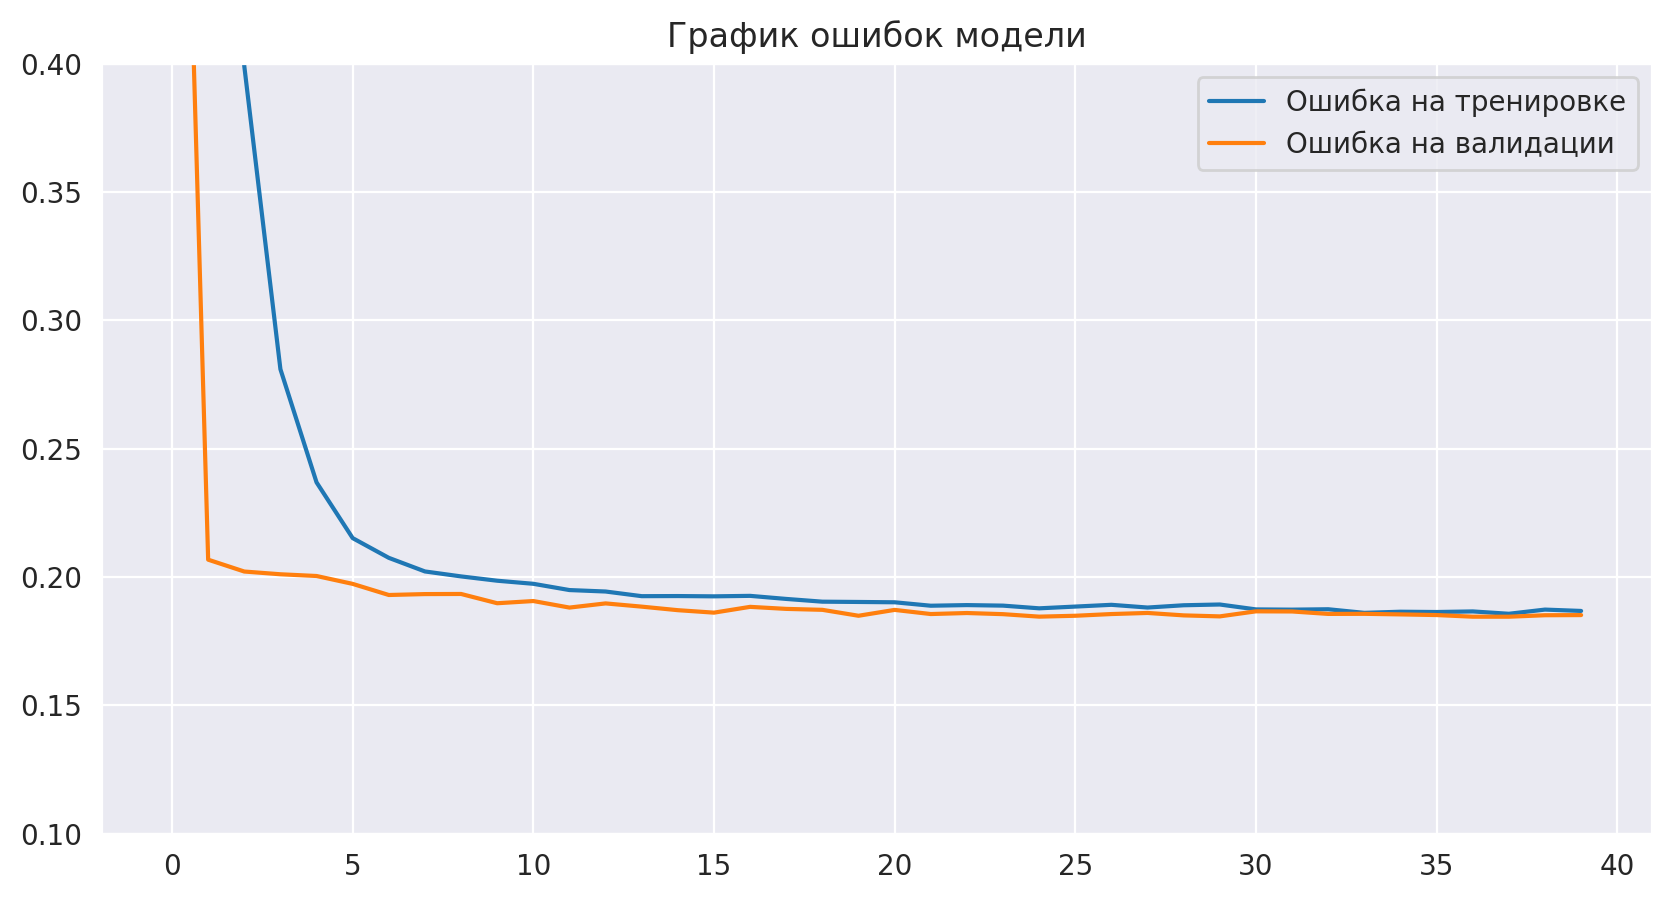

In [110]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(train_losses, label='Ошибка на тренировке')
plt.plot(val_losses, label='Ошибка на валидации')
plt.title('График ошибок модели')
plt.ylim([0.1, 0.4])
plt.legend()

In [76]:
def r2_score(y_true, y_pred):
    y_true_mean = torch.mean(y_true)
    ss_total = torch.sum((y_true - y_true_mean) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_residual / ss_total
    return r2.item()

In [111]:
y_preds = torch.cat(y_preds)
y_trues = torch.cat(y_trues)
r2_score(y_trues, y_preds)

0.251178503036499